In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from tqdm import tqdm

def seedEverything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed=42
seedEverything(seed)

fontSizeSetLarge=18
fontSizeSetMedium=14
signalLims=[(0,50000),(0,5000), (0,2500), (0,4500)]
pceLims=(5,17.5)
vocLims=(0.9,1.15)
jscLims=(16,22)
ffLims=(40,75)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
filename='data/data.h5'

## read in and preprocess data

In [3]:
# Read the HDF5 file into a DataFrame
readDF=pd.read_hdf(filename, 'df') 
# Filter the DataFrame based on date, standard ratio, and standard molarity
readDF=readDF[(readDF["date"]>20230724) &(readDF["ratio"]==1) & (readDF["molarity"]==0.67)]

# List of signal types to process
signals=["ND","LP725","LP780","SP775"]

# Pad signals in the DataFrame to have the same length (1979)
for iy, signal in enumerate(signals):
    for ix in range(len(readDF)):
        temp1=readDF.loc[readDF.index[ix],signal]
        
        # Calculate how much padding is required and perform padding
        values_to_add = 1979 - len(temp1)
        constant_value = 0  
        temp1_padded = np.concatenate((temp1, [constant_value] * values_to_add))
        
        # Update the DataFrame with padded signals
        readDF.at[readDF.index[ix],signal]=temp1_padded
        
# Define samples that will be used as training data        
train_samples=[ 'DHM', 'DHN', 'DHO', 'DHP', 'DHQ' ,'DHR' ,
               'DGS', 'DGT', 'DGU' ,'DGV', 'DGW', 'DGX','DHS', 
               'DFS','DFT', 'DFU' ,'DFV', 'DFW' ,'DFX','DGR',
               'DEV' ,'DEW', 'DEX' ,'DFQ', 'DFR' ,'DGP','DGQ',
               'DAC', 'DAH' ,'DAM', 'DBC' ,'DBH', 'DBM', 'DBR', 'DCA', 'DCI', 'DDM', 'DDN' ,'DDO',
               'DDP', 'DDQ', 'DDR' ,'DDS' ,'DDT', 'DDU' ,'DDV', 'DDW' ,'DDX', 'DEM', 'DEN',
               'DES' ,'DET', 'DEU', 'DFO', 'DFP','DGM', 'DHV', 'DHW', 'DHX', 'DIU', 'DIV' ]

# Define sub-lists for different training folds during 5-fold cross-validation
train_fold0_sub_list=['DHM',  'DHR',  'DGW',  'DFU', 'DEV',  'DGP', 'DFO', 'DHX', 'DDO',  'DDT', 'DEM' ]
train_fold1_sub_list=[ 'DHN', 'DGS', 'DGX' , 'DFV', 'DEW', 'DGQ',  'DFP',  'DIU', 'DDP', 'DDU', 'DEN']
train_fold2_sub_list=[ 'DHO',  'DGT' , 'DHS',  'DFW', 'DEX', 'DES',  'DGM',  'DIV',  'DDQ',  'DDV']
train_fold3_sub_list=[ 'DHP', 'DGU', 'DFS' ,  'DFX' ,  'DFQ',  'DET', 'DHV', 'DDM', 'DDR',  'DDW']
train_fold4_sub_list=[ 'DHQ',  'DGV', 'DFT', 'DGR', 'DFR', 'DEU', 'DHW',  'DDN', 'DDS',  'DDX'  ]

# Drop samples not in any fold from the training DataFrame and reset its index
indexDropTrain = readDF[ ~readDF['expID'].isin(train_fold0_sub_list+train_fold1_sub_list+train_fold2_sub_list+train_fold3_sub_list+train_fold4_sub_list ) ].index
trainDF=readDF.drop(indexDropTrain)
trainDF=trainDF.reset_index(drop=True)

# Assigning fold numbers to each sample in trainDF
for element in trainDF[trainDF['expID'].isin(train_fold0_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=0
for element in trainDF[trainDF['expID'].isin(train_fold1_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=1
for element in trainDF[trainDF['expID'].isin(train_fold2_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=2
for element in trainDF[trainDF['expID'].isin(train_fold3_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=3
for element in trainDF[trainDF['expID'].isin(train_fold4_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=4
    
# Drop the train samples from the DataFrame to create a test set and reset its index
indexDropTest = readDF[ readDF['expID'].isin(train_samples) ].index
testDF=readDF.drop(indexDropTest)
testDF=testDF.reset_index(drop=True)

def filter(df):
    # Filter out rows where 'PCE_backward' is not available
    df=df[df['PCE_backward'].notna()]
    
    # Set threshold for 'PCE_backward' to be used
    thres_PCE=1
    
    # Filter the DataFrame to include only rows where 'PCE_backward' is larger than the threshold
    if thres_PCE>0:
        df=df[df['PCE_backward']>thres_PCE]
    
    df=df.reset_index(drop=True)
    
    return df

# Apply the `filter` function to the training and testing DataFrames.
# This ensures that only entries with 'PCE_backward' values above the threshold are retained.
trainDF, testDF = [filter(df) for df in (trainDF, testDF)]  

## Plotting training data for different quenching durations

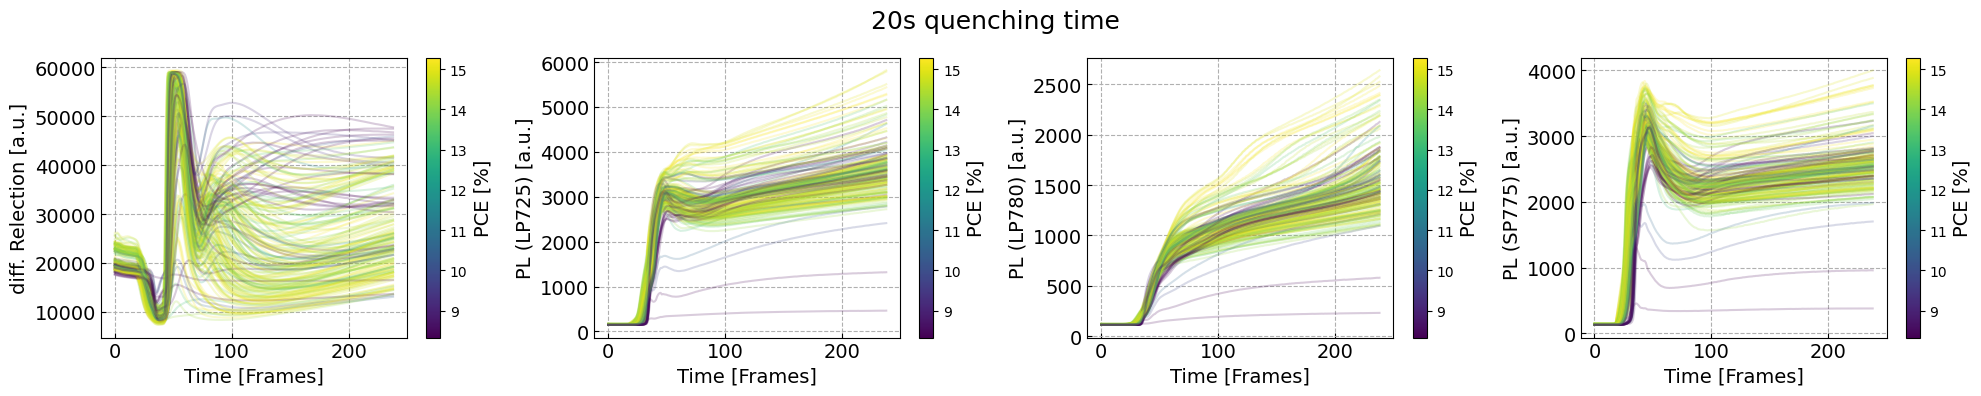

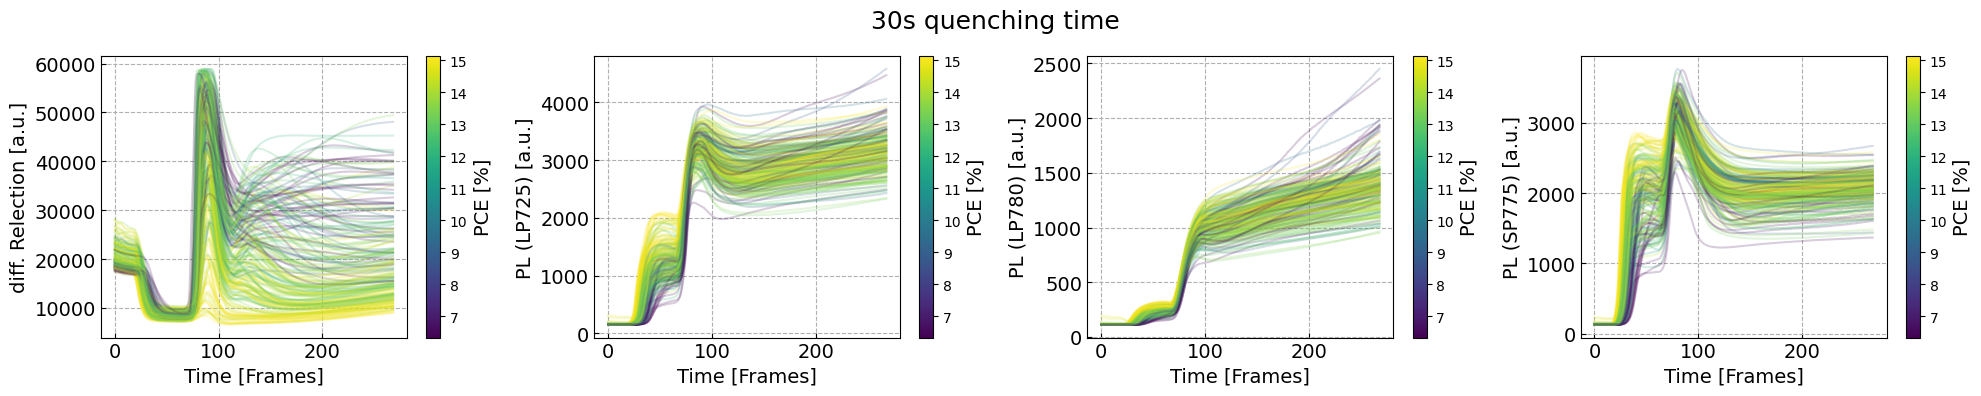

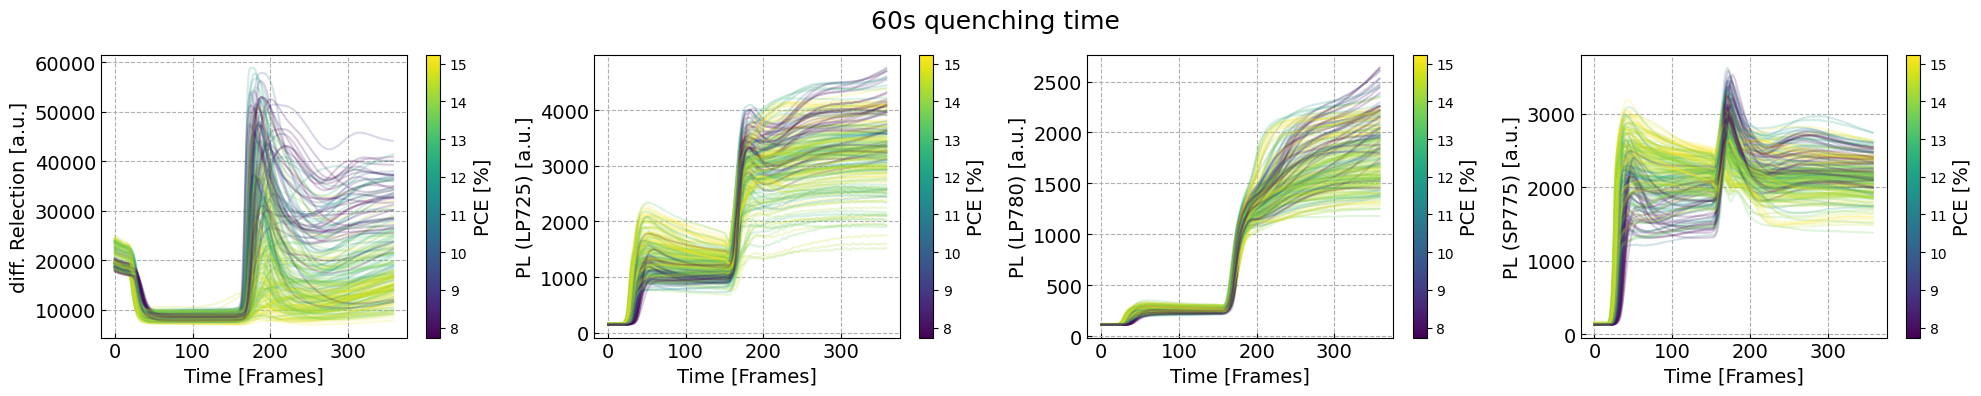

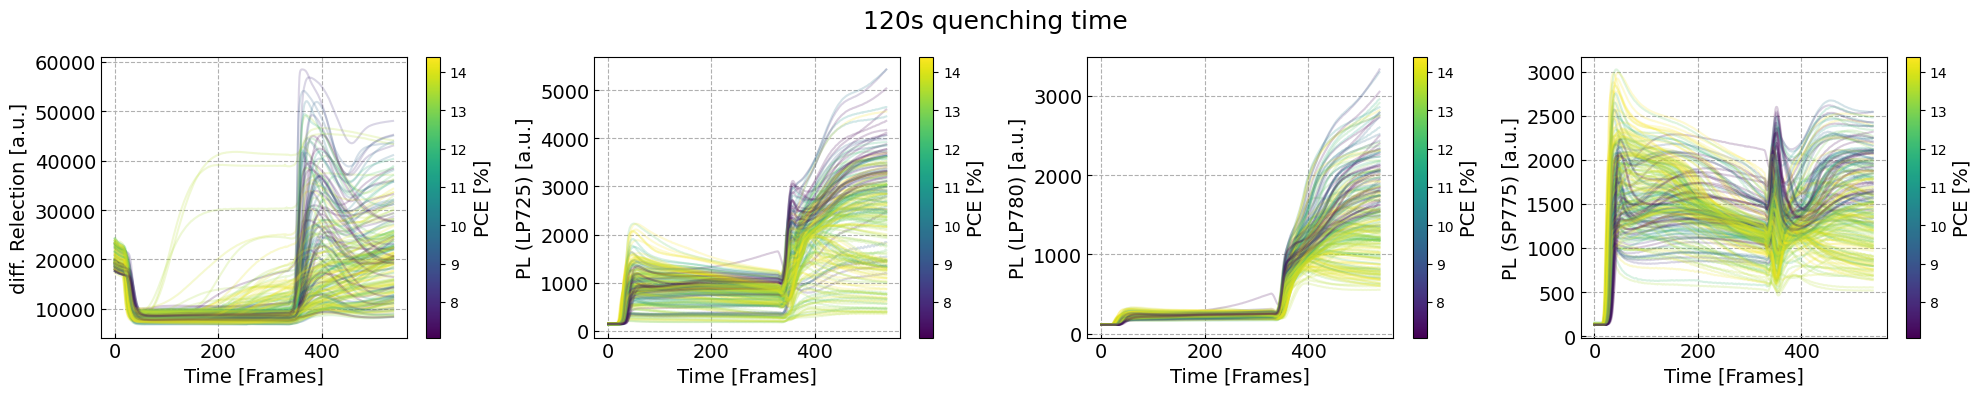

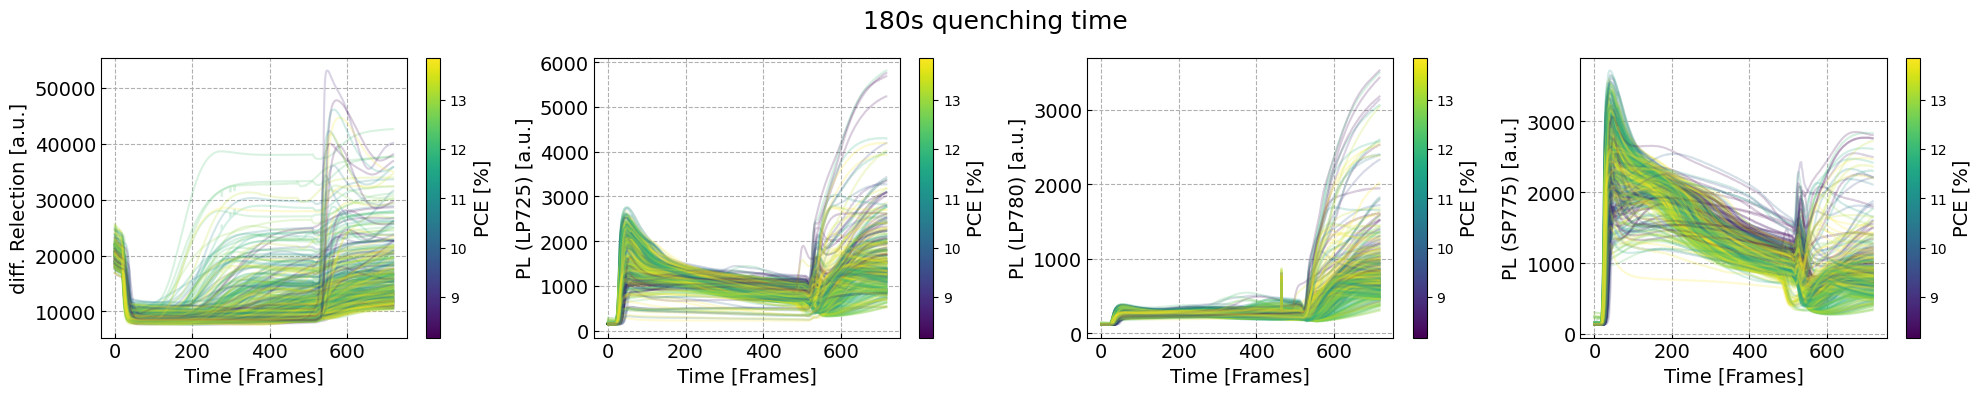

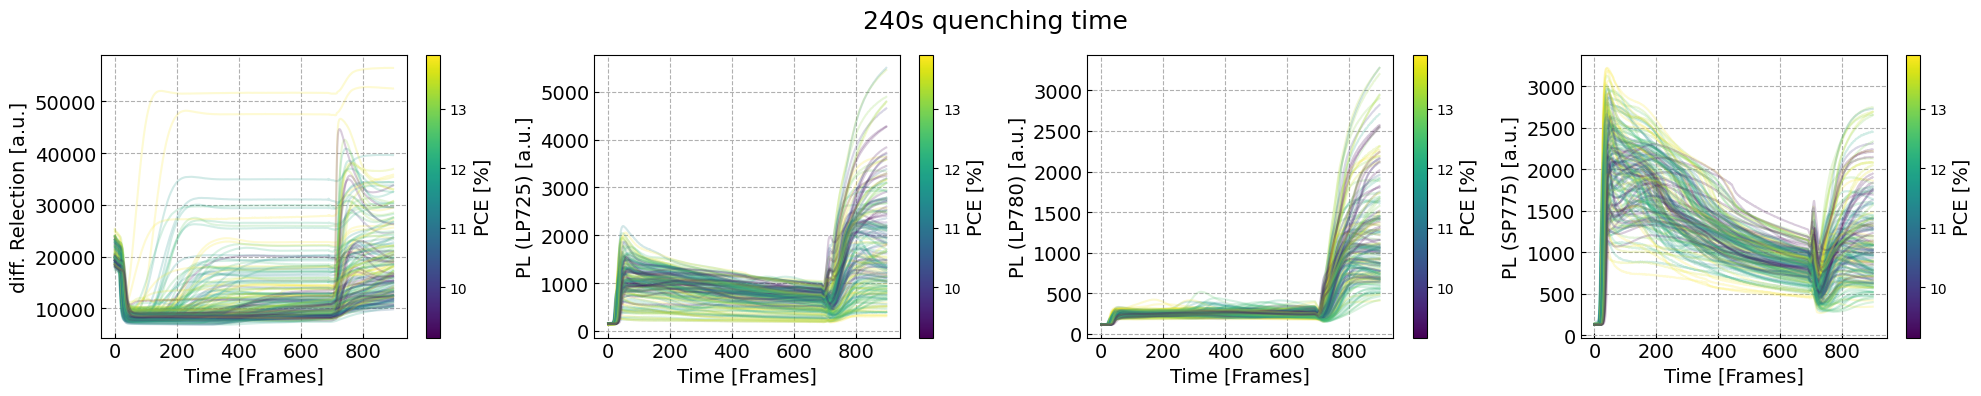

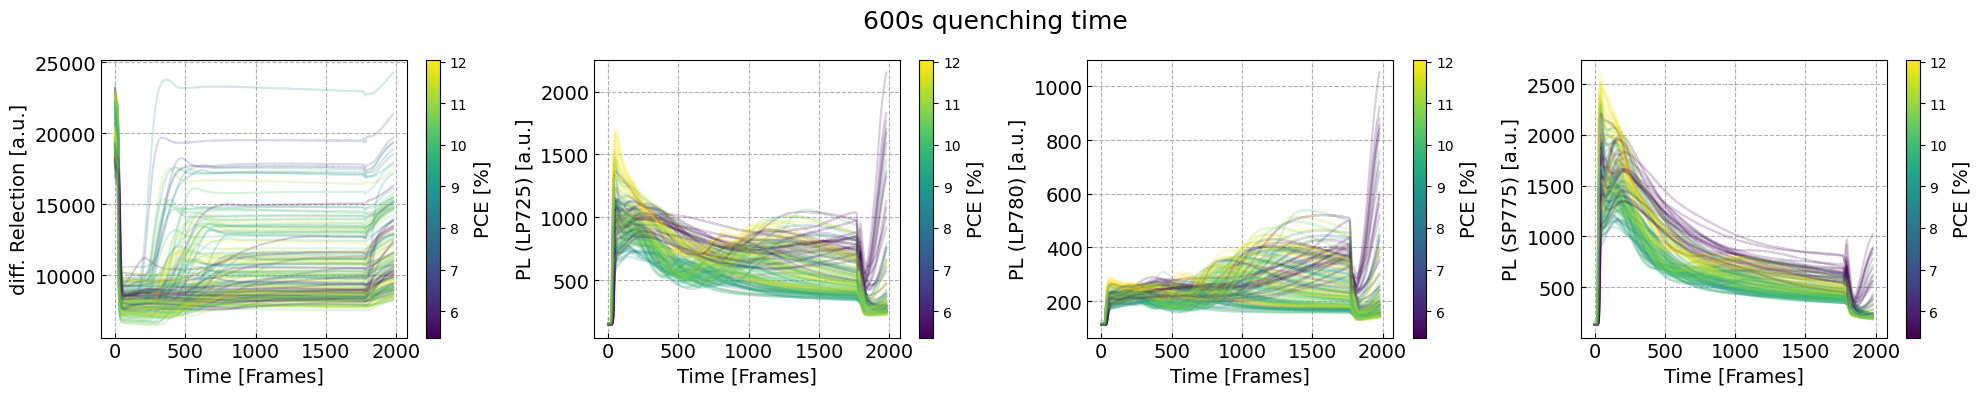

In [4]:
# Labels for quenching durations to be used in plot titles
labels=["20s", "30s", "60s", "120s", "180s", "240s", "600s"]

# Iterate through sorted unique quenching durations present in the training DataFrame
for inn, evac_duration in enumerate(sorted(trainDF["evac_duration"].unique())):
    temp= trainDF[trainDF["evac_duration"]==evac_duration]

    # Get 10 and 90 percentile to enable color-coding the PCE 
    maxPCE=np.percentile(temp["PCE_backward"],90)
    minPCE=np.percentile(temp["PCE_backward"],10)
    
    # Create subplots for the signals for the current quenching duration
    fig,ax =plt.subplots(1,4, figsize=(20,4))
    for iy, signal in enumerate(signals):
        
        # Plot each sample's signal for the current quenching duration
        for ix in range(len(temp)):
            # Get signal for current sample
            sig=temp.loc[temp.index[ix],signal][0: int(evac_duration)-1]
            # Get PCE of current sample for color coding
            pce=temp.loc[temp.index[ix],"PCE_backward"]
            pce_colornumber=(pce-minPCE)/(maxPCE-minPCE)
            ax[iy].plot(sig, color=cm.viridis(pce_colornumber), alpha=0.2)
            
        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=minPCE, vmax=maxPCE))
        cbar=plt.colorbar(sm, ax=ax[iy])
        cbar.set_label('PCE [%]', fontsize=14)
        ax[iy].set_xlabel("Time [Frames]", fontsize=14)
        ax[iy].grid(which="both", linestyle='--')
        ax[iy].tick_params(axis='both', which='major',direction="in", labelsize=14)
        
    fig.suptitle(labels[inn] +" quenching time", fontsize=18)                           
    ax[0].set_ylabel("diff. Relection [a.u.]", fontsize=14)
    ax[1].set_ylabel("PL (LP725) [a.u.]", fontsize=14)
    ax[2].set_ylabel("PL (LP780) [a.u.]", fontsize=14)
    ax[3].set_ylabel("PL (SP775) [a.u.]", fontsize=14)
    plt.tight_layout()
    plt.show()



## Training a neural network for predicting PCE

In [5]:
# Definition of a neural network model
class NN_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN_Model, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 500)
        self.fc5 = nn.Linear(500, 200)
        self.fc6 = nn.Linear(200, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)

        return x

****************************************************************************************************
*                                                                                                  *
*                      training on training set using 5-fold cross-validation                      *
*                                                                                                  *
****************************************************************************************************
fold 0  (train_size: 1276 , valid_size: 330 )


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


validation result for fold 0 :   mae:  1.38
****************************************************************************************************
fold 1  (train_size: 1268 , valid_size: 338 )


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


validation result for fold 1 :   mae:  1.26
****************************************************************************************************
fold 2  (train_size: 1292 , valid_size: 314 )


100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]


validation result for fold 2 :   mae:  1.46
****************************************************************************************************
fold 3  (train_size: 1296 , valid_size: 310 )


100%|██████████| 1000/1000 [00:53<00:00, 18.72it/s]


validation result for fold 3 :   mae:  1.19
****************************************************************************************************
fold 4  (train_size: 1292 , valid_size: 314 )


100%|██████████| 1000/1000 [00:54<00:00, 18.47it/s]


validation result for fold 4 :   mae:  1.47
****************************************************************************************************


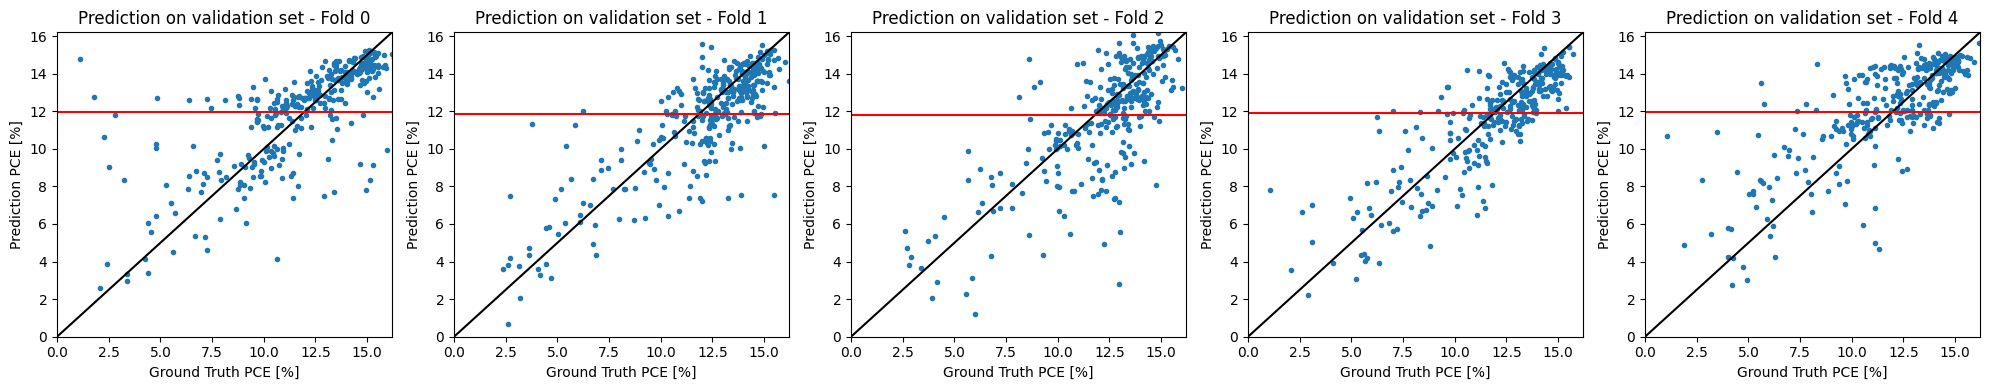

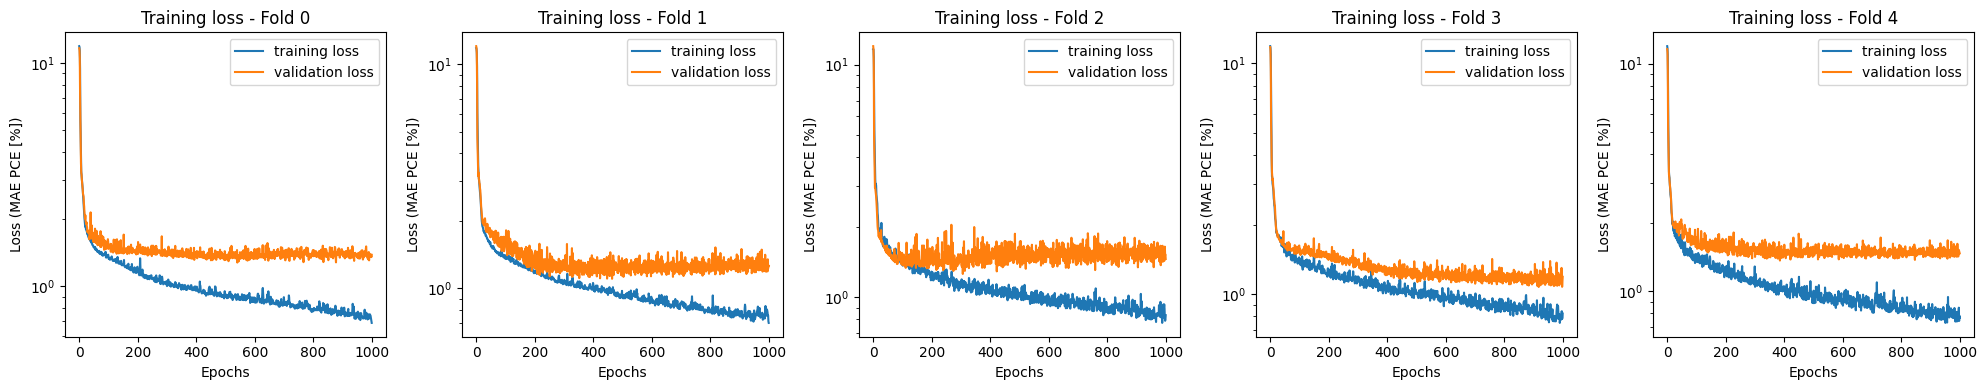

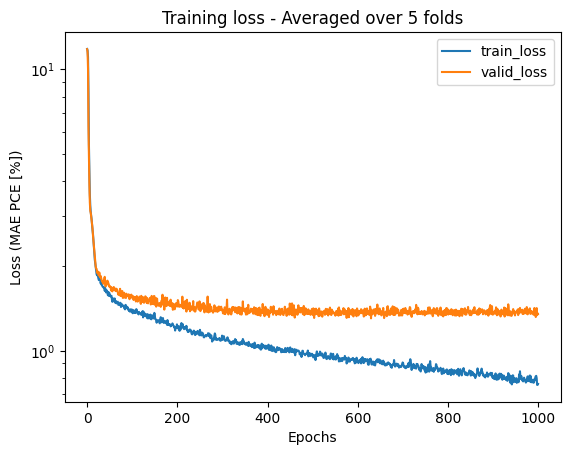

last loss 1.35 , best loss: 1.3  for 629 epochs
****************************************************************************************************
*                                                                                                  *
*                          training on entire train set (for  630  epochs)                         *
*                                                                                                  *
****************************************************************************************************


100%|██████████| 629/629 [00:35<00:00, 17.58it/s]


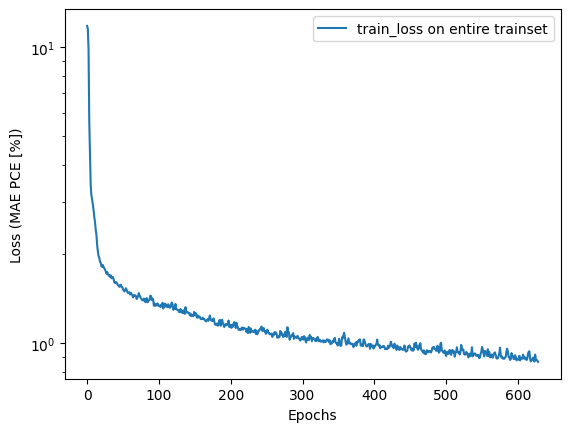

****************************************************************************************************
*                                                                                                  *
*                                    testing on held-out testset                                   *
*                                                                                                  *
****************************************************************************************************


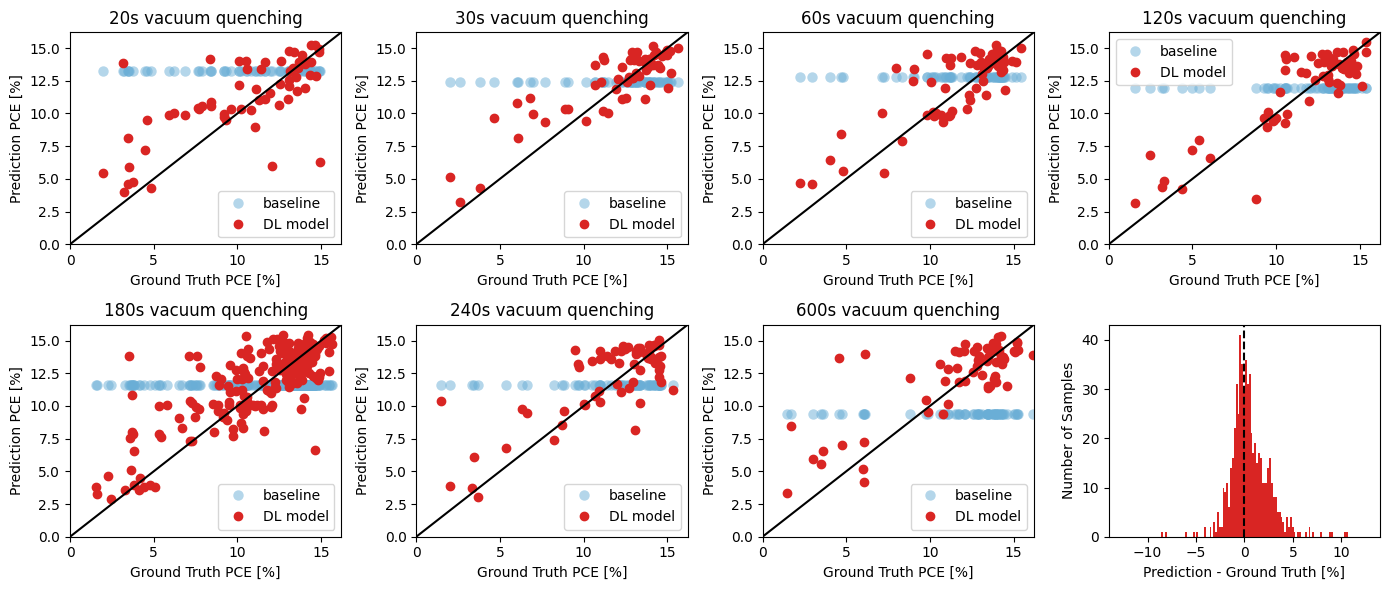

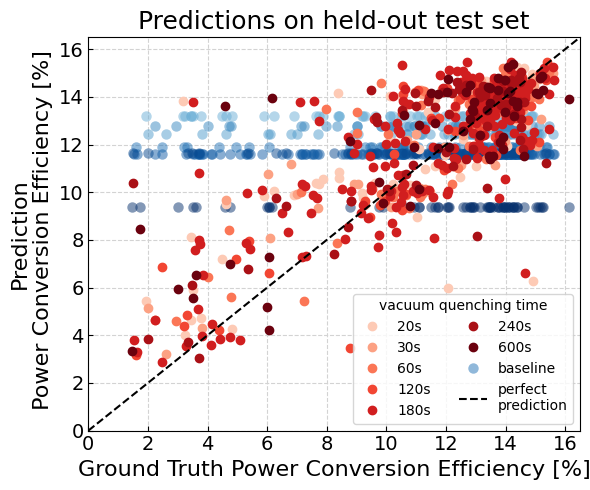

testing result on entire held-out test set:         mae:  1.44      mae_baseline:  2.55
----------------------------------------------------------------------
test subset - with quenching duration: 20s        mae:  1.93 ,      mae_baseline:  2.95
test subset - with quenching duration: 30s        mae:  1.25 ,      mae_baseline:  3.1
test subset - with quenching duration: 60s        mae:  1.35 ,      mae_baseline:  2.43
test subset - with quenching duration: 120s        mae:  1.21 ,      mae_baseline:  3.3
test subset - with quenching duration: 180s        mae:  1.38 ,      mae_baseline:  2.05
test subset - with quenching duration: 240s        mae:  1.56 ,      mae_baseline:  2.28
test subset - with quenching duration: 600s        mae:  1.59 ,      mae_baseline:  3.06


In [6]:
seedEverything(seed)
# Scaler value for normalizing data
scaler=2**16

# Training parameters
learning_rate = 0.0001
batch_size = 128
shuffle = True # Shuffle data in the DataLoader
num_epochs=1000 # Number of training epochs
criterion = nn.L1Loss() # Loss function for regression / L1 equals MAE
optimize=optim.Adam # Optimization algorithm
weight_decay=0.0001 # Weight decay for regularization
model_to_use=NN_Model

print("*"*100)
print("*", " "*96,"*")
print("*"," "*20, "training on training set using 5-fold cross-validation"," "*20,"*")
print("*", " "*96,"*")
print("*"*100)

# Lists for storing fold-wise losses
valid_fold_losses=[]
train_fold_losses=[]
fig,ax=plt.subplots(1,5,figsize=(20,4))
last_mae=[]

# 5-fold cross-validation
for fold in range(5):
    
    # Splitting the training dataset into training and validation sets based on fold      
    temp_train=trainDF[trainDF["fold"]!=fold].copy()
    temp_valid=trainDF[trainDF["fold"]==fold].copy()
    
    # Data preprocessing: feature extraction, normalization, and conversion to tensors
    X_train = pd.DataFrame(data = np.hstack((np.vstack(temp_train["ND"].to_numpy()),np.vstack(temp_train["LP725"].to_numpy()),
                np.vstack(temp_train["LP780"].to_numpy()),np.vstack(temp_train["SP775"].to_numpy()))))/scaler
    X_valid = pd.DataFrame(data = np.hstack((np.vstack(temp_valid["ND"].to_numpy()),np.vstack(temp_valid["LP725"].to_numpy()),
                np.vstack(temp_valid["LP780"].to_numpy()),np.vstack(temp_valid["SP775"].to_numpy()))))/scaler
    
    y_train=pd.DataFrame(data=np.vstack(temp_train["PCE_backward"].to_numpy()))
    y_valid=pd.DataFrame(data=np.vstack(temp_valid["PCE_backward"].to_numpy()))
    
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32)) 
    X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
    y_valid_tensor = torch.tensor(y_valid.values.astype(np.float32)) 

    # DataLoader setup for both training and validation sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
    valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=shuffle)

    print("fold", fold, " (train_size:" , len(train_dataset),", valid_size:" , len(valid_dataset), ")")
    
    # Model initialization and optimizer setup
    input_size =  X_train.shape[1]  
    output_size = y_train.shape[1]  
    model = model_to_use(input_size, output_size).to(device)
    optimizer = optimize(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Lists for storing epoch-wise losses for the current fold
    valid_fold_losses.append([])
    train_fold_losses.append([])
    
    # Training and validation loop
    for epoch in tqdm(range(num_epochs)):
        epoch_train_loss=[]
        epoch_valid_loss=[]
        
        # Training the model on 4 train splits
        for inputs, targets in train_loader:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))     
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.cpu().detach().numpy() )

        # Validating the model on 1 validation split
        for inputs_valid, targets_valid in valid_loader:
            model.eval()
            outputs_valid = model(inputs_valid.to(device))
            loss_valid = criterion(outputs_valid, targets_valid.to(device)).cpu().detach().numpy()   
            epoch_valid_loss.append(loss_valid)

        # Update epoch-wise losses for the current fold
        train_fold_losses[fold].append(np.mean(epoch_train_loss))    
        valid_fold_losses[fold].append(np.mean(epoch_valid_loss))

    mae = mean_absolute_error(targets_valid.to(device).cpu().detach().numpy(), outputs_valid.to(device).cpu().detach().numpy())
    last_mae.append(mae)
    print("validation result for fold", fold, ":   mae: ", np.round(mae,2))
    print("*"*100)
    
    # Plotting parity plot for predictions on the validation set of the current fold
    ax[fold].plot(targets_valid.to(device).cpu().detach().numpy()  , outputs_valid.to(device).cpu().detach().numpy() , ".")
    ax[fold].axline((10, 10), slope=1, color='k')
    ax[fold].axline((10, np.mean(y_train)), slope=0, color='r')
    ax[fold].set_ylabel("Prediction PCE [%]")
    ax[fold].set_xlabel("Ground Truth PCE [%]")
    ax[fold].set_xlim(0,16.2)
    ax[fold].set_ylim(0,16.2)
    ax[fold].set_title("Prediction on validation set - Fold " + str(fold))
    
fig.tight_layout()    
plt.show()

# Plot training and validation loss curves for each fold
fig,ax=plt.subplots(1,fold+1,figsize=(20,4))
for fold in range(len(train_fold_losses)):
    ax[fold].plot(train_fold_losses[fold], "tab:blue")
    ax[fold].plot([],[], "tab:blue", label="training loss")
    ax[fold].plot(valid_fold_losses[fold], "tab:orange")
    ax[fold].plot([],[], "tab:orange", label="validation loss")    
    ax[fold].legend()
    ax[fold].set_title("Training loss - Fold " + str(fold))
    ax[fold].set_yscale('log')
    ax[fold].set_ylabel("Loss (MAE PCE [%])")
    ax[fold].set_xlabel("Epochs")
fig.tight_layout()
plt.show()

# Plot training and validation loss curves averaged over folds
plt.plot(np.mean(train_fold_losses,axis=0), label="train_loss")
plt.plot(np.mean(valid_fold_losses,axis=0), label="valid_loss")
plt.yscale('log')
plt.ylabel("Loss (MAE PCE [%])")
plt.xlabel("Epochs")
plt.title("Training loss - Averaged over 5 folds")
plt.legend()
plt.show()

# Find the epoch with the best average validation loss across folds
epochs_testing=np.argmin(np.mean(valid_fold_losses,axis=0))
print("last loss",np.round(np.mean(last_mae),2), ", best loss:", np.round(np.mean(valid_fold_losses,axis=0)[epochs_testing],2), " for", epochs_testing, "epochs")

print("*"*100)
print("*", " "*96,"*")
print("*"," "*24, "training on entire train set (for ",epochs_testing+1," epochs)"," "*23,"*")
print("*", " "*96,"*")
print("*"*100)

input_size =  X_train.shape[1]  
output_size = y_train.shape[1]  
model = model_to_use(input_size, output_size).to(device)
optimizer = optimize(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data preprocessing for using the entire training set: feature extraction, normalization, and conversion to tensors
X_train = pd.DataFrame(data = np.hstack((np.vstack(trainDF["ND"].to_numpy()),np.vstack(trainDF["LP725"].to_numpy()),
            np.vstack(trainDF["LP780"].to_numpy()),np.vstack(trainDF["SP775"].to_numpy()))))/scaler
y_train=pd.DataFrame(data=np.vstack(trainDF["PCE_backward"].to_numpy()))

X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)) 

# DataLoader setup for training on entire training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

entireTrainset_losses=[]

# Final training on the entire training set using the optimal number of epochs
for epoch in tqdm(range(epochs_testing)):
    entireTrainset_loss=[]   
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))     
        loss.backward()
        optimizer.step()
        entireTrainset_loss.append(loss.cpu().detach().numpy() )

    entireTrainset_losses.append(np.mean(entireTrainset_loss))
    
plt.plot(entireTrainset_losses, label="train_loss on entire trainset")
plt.yscale('log')
plt.ylabel("Loss (MAE PCE [%])")
plt.xlabel("Epochs")
plt.legend()
plt.show()

print("*"*100)
print("*", " "*96,"*")
print("*"," "*34, "testing on held-out testset"," "*33,"*")
print("*", " "*96,"*")
print("*"*100)

# Data preprocessing for testing on the test set: feature extraction, normalization, and conversion to tensors
X_test = pd.DataFrame(data = np.hstack((np.vstack(testDF["ND"].to_numpy()),np.vstack(testDF["LP725"].to_numpy()),
            np.vstack(testDF["LP780"].to_numpy()),np.vstack(testDF["SP775"].to_numpy()))))/scaler
y_test=pd.DataFrame(data=np.vstack(testDF["PCE_backward"].to_numpy()))    

X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)) 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=shuffle)

# Testing on the held-out test set
for inputs_test, targets_test in test_loader:
    model.eval()
    outputs_test = model(inputs_test.to(device))
    loss_test = criterion(outputs_test, targets_test.to(device)).cpu().detach().numpy() 

y_target=targets_test.cpu().detach().numpy()
y_pred=outputs_test.cpu().detach().numpy()

# Plot confusion prediction results of the test samples
labels=["20s", "30s", "60s", "120s", "180s", "240s", "600s", "hist"]
fig, ax = plt.subplots(2,4, figsize=(14,6))
# Iterate through each unique evacuation duration in the test dataset
for ix, duration in enumerate(sorted(testDF["evac_duration"].unique())):
    temp=testDF[testDF["evac_duration"]==duration]
    temp_train=trainDF[trainDF["evac_duration"]==duration]
    # Plot the baseline PCE for each evacuation duration
    ax[ix//4,ix%4].plot(y_target[temp.index],[np.mean(temp_train["PCE_backward"])]*len(temp.index),'.',ms=15,markeredgecolor='none',alpha=0.5,color=plt.get_cmap('Blues')(0.5), label="baseline")
    # Plot the DL model's predicted PCE for each evacuation duration
    ax[ix//4,ix%4].plot(y_target[temp.index],y_pred[temp.index,0], 'o',color=plt.get_cmap('Reds')(0.7), label="DL model")
    ax[ix//4,ix%4].axline((10, 10), slope=1, color='k')
    ax[ix//4,ix%4].set_ylabel("Prediction PCE [%]")
    ax[ix//4,ix%4].set_xlabel("Ground Truth PCE [%]")
    ax[ix//4,ix%4].set_ylim(0,16.2)
    ax[ix//4,ix%4].set_xlim(0,16.2)
    ax[ix//4,ix%4].set_title(labels[ix]+ " vacuum quenching")
    ax[ix//4,ix%4].legend()
# Plot histogram of prediction errors
ax[1,3].hist(y_pred.reshape(-1)-y_target.reshape(-1),bins=100, color=plt.get_cmap('Reds')(0.7))
ax[1,3].axvline(x=0, color='k', linestyle='--')
ax[1,3].set_xlabel("Prediction - Ground Truth [%]")
ax[1,3].set_ylabel("Number of Samples")
ax[1,3].set_xlim(-14,14)
plt.tight_layout()
plt.show()

# Generate color maps for plotting
ks = np.linspace(0.2,0.99,len(testDF["evac_duration"].unique()))
ks2 = np.linspace(0.5,0.99,len(testDF["evac_duration"].unique()))
color_list_fig = []
color_list_fig_2 = []
cmap = plt.get_cmap('Reds')
cmap2 = plt.get_cmap('Blues')
for zz in range(len(ks)):
    color_list_fig.append(cmap(ks[zz]))
    color_list_fig_2.append(cmap2(ks2[zz]))

labels=["20s", "30s", "60s", "120s", "180s", "240s", "600s"]
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# Plot the baseline PCE for each evacuation duration
for ix, duration in enumerate(sorted(testDF["evac_duration"].unique())):
    temp=testDF[testDF["evac_duration"]==duration]
    temp_train=trainDF[trainDF["evac_duration"]==duration]  
    ax.plot(y_target[temp.index],[np.mean(temp_train["PCE_backward"])]*len(temp.index),'.',ms=15,markeredgecolor='none',alpha=0.5,color=color_list_fig_2[ix])
# Plot the DL model's predicted PCE for each evacuation duration
for ix, duration in enumerate(sorted(testDF["evac_duration"].unique())):
    temp=testDF[testDF["evac_duration"]==duration]
    ax.plot(y_target[temp.index],y_pred[temp.index,0], 'o', color=color_list_fig[ix],label=labels[ix])
ax.plot([],[], '.',ms=15,markeredgecolor='none',alpha=0.5, color=color_list_fig_2[3],label="baseline" )
ax.set_title('Predictions on held-out test set', fontsize=18)
ax.grid(which="both", linestyle='--', color="lightgrey")
ax.tick_params(axis='both', which='major',direction="in", labelsize=14) 
ax.axline((10, 10), slope=1, linestyle='--', color='k', label="perfect\nprediction")
ax.set_ylabel("Prediction\n Power Conversion Efficiency [%]", fontsize=16)
ax.set_xlabel("Ground Truth Power Conversion Efficiency [%]", fontsize=16)
ax.set_ylim(0,16.5)
ax.set_xlim(0,16.5)
ax.set_xticks([0,2,4,6,8,10,12,14,16])
ax.set_yticks([0,2,4,6,8,10,12,14,16])
plt.legend(title="vacuum quenching time", ncol=2)
fig.tight_layout()
plt.show()

# Print the results for the entire test set
mae = mean_absolute_error(y_target, y_pred)
dummy1=DummyRegressor(strategy='mean').fit(X_train, y_train)
mae_dummy = mean_absolute_error(y_test, dummy1.predict(X_test))
print("testing result on entire held-out test set:         mae: ", np.round(mae,2), "     mae_baseline: ", np.round(mae_dummy,2))
print("-------"*10)

# Print the MAE for the model and the baseline for each evacuation duration subset
for ix, duration in enumerate(sorted(testDF["evac_duration"].unique())):
    temp=testDF[testDF["evac_duration"]==duration]
    mae = mean_absolute_error(y_pred[temp.index],y_target[temp.index])
    mae_dummy = mean_absolute_error(y_test.loc[temp.index], dummy1.predict(X_test.loc[temp.index]))
    print("test subset - with quenching duration:", labels[ix], "       mae: ", np.round(mae,2), ",      mae_baseline: ", np.round(mae_dummy,2))    